# Title: 

In [103]:
# packages

import datetime as dt
from loguru import logger
import numpy as np
import pandas as pd
from tqdm import tqdm

from quantified_strategies import strategy_utils

import constants
import model
import utils

In [104]:
import torch
from quantified_strategies import loss

def my_cagr_loss(weights: torch.Tensor, returns: torch.Tensor, **kwargs) -> torch.Tensor:


    port_return = weights * returns
    try:
        port_return = torch.sum(port_return, dim=1)
    except IndexError:
        pass

    long_overnight_costs = loss.calc_long_overnight_cost(weights=weights, long_costs=kwargs.get("long_costs"), n_days=kwargs.get("n_days"))
    short_overnight_costs = loss.calc_short_overnight_cost(weights=weights, short_costs=kwargs.get("short_costs"), n_days=kwargs.get("n_days"))
    overnight_costs = long_overnight_costs + short_overnight_costs
        
    port_return = port_return - overnight_costs

    active_weights = 1 - weights[:, -1]
    active_port_return = port_return[torch.abs(active_weights) > 1e-5]
    mu_return = torch.mean(active_port_return)

    std_return = torch.std(active_port_return) if active_port_return.shape[0] > 3 else 0.01
    
    sharpe = mu_return / (std_return + 1e-8)
    multiplier = 252.0 * torch.sum(active_weights) / (len(active_weights) + 1e-8)
    ann_sharpe = sharpe * torch.sqrt(multiplier)

    return ann_sharpe


In [65]:
# parameters

# Trading Parameters
ASSETS = ["VUSA.LSE", "CNX1.LSE", utils.CASH]
FILE = "strategy_returns_us_european_etfs.csv"
# ASSETS = ["SPY.US", "QQQ.US", "XLC.US", "XLE.US", "XLF.US", "XLI.US", "XLK.US", "XLP.US", "XLRE.US", "XLU.US", "XLY.US", "XLV.US", utils.CASH]
# FILE = "strategy_returns_us_sector_american_etfs.csv"
START = dt.date(2010, 1, 1)
END = dt.date.today()

# Training Parameters
MIN_TRAINING_YEARS = 6

# Algorithm Parameters
LOSS_FUNCTION = my_cagr_loss
MAXIMIZE_LOSS = True
BATCH_SIZE = 64
EPOCHS = 2_000
LEARNING_RATE = 0.0001

# Allocation Parameters
ALLOW_NEGATIVE_WEIGHTS = False
MAX_LEVERAGE_WEIGHT = 1.5
MIN_LEVERAGE_WEIGHT = (MAX_LEVERAGE_WEIGHT - 1) / (len(ASSETS) - 1)
MAX_WEIGHT = MAX_LEVERAGE_WEIGHT if ALLOW_NEGATIVE_WEIGHTS else 1.0
MIN_WEIGHT = MIN_LEVERAGE_WEIGHT if ALLOW_NEGATIVE_WEIGHTS else 0.0

# Other Parameters
STORE = False

# Fetch costs involved in trading assets
LONG_OVERNIGHT_COSTS = [constants.LONG_OVERNIGHT_COSTS_DICT.get(asset, 0.0) for asset in ASSETS]
SHORT_OVERNIGHT_COSTS = [constants.SHORT_OVERNIGHT_COSTS_DICT.get(asset, 0.0) for asset in ASSETS]

In [66]:
ASSETS = ["VUSA.LSE", "CNX1.LSE", utils.CASH]
FILE = "strategy_returns_us_european_etfs.csv"

ASSETS = ["SPY.US", "QQQ.US", utils.CASH]
FILE = "strategy_returns_us_american_etfs.csv"

In [67]:

strategy_returns = pd.read_csv(f"../outputs/{FILE}", index_col=0, parse_dates=True, header=[0, 1, 2])
asset_returns = pd.concat([strategy_utils.get_data(ticker=ticker, columns="Adj Close").to_frame(ticker).pct_change() for ticker in ASSETS], axis=1)

strategy_returns = strategy_returns.loc[(strategy_returns.index.date >= START) & (strategy_returns.index.date <= END)]
asset_returns = asset_returns.loc[(asset_returns.index.date >= START) & (asset_returns.index.date <= END)]

{}
remove api from here
{}
remove api from here
{}
remove api from here


In [89]:
cum_strat_returns = strategy_utils.get_cumulative_return(returns=strategy_returns.fillna(0.0), total=False)
strat_active = (~strategy_returns.iloc[:, 4:6].shift(1).isna()).groupby(level=2, axis=1).sum().reindex(index=asset_returns.index, method="ffill")
strat_active = (~strategy_returns.shift(1).isna()).groupby(level=2, axis=1).sum().reindex(index=asset_returns.index, method="ffill")
strat_active

C:\Users\tomw1\AppData\Local\Temp\ipykernel_14492\2043566557.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  strat_active = (~strategy_returns.iloc[:, 4:6].shift(1).isna()).groupby(level=2, axis=1).sum().reindex(index=asset_returns.index, method="ffill")
C:\Users\tomw1\AppData\Local\Temp\ipykernel_14492\2043566557.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  strat_active = (~strategy_returns.shift(1).isna()).groupby(level=2, axis=1).sum().reindex(index=asset_returns.index, method="ffill")


,QQQ.US,SPY.US
Date,,
2010-01-04,0,0
2010-01-05,2,2
2010-01-06,2,2
2010-01-07,1,1
2010-01-08,1,1
...,...,...
2024-02-27,3,3
2024-02-28,2,2
2024-02-29,2,2


In [90]:
asset = "QQQ.US"
r = asset_returns[asset]
r

Date
2010-01-04    0.014646
2010-01-05    0.000000
2010-01-06   -0.006031
2010-01-07    0.000650
2010-01-08    0.008229
                ...   
2024-02-27    0.002405
2024-02-28   -0.005324
2024-02-29    0.008569
2024-03-01    0.015057
2024-03-04   -0.003568
Name: QQQ.US, Length: 3565, dtype: float64

In [91]:
ra = asset_returns.loc[(strat_active[asset] >= 1), asset].reindex(index=asset_returns.index, fill_value=0.0)
ra

Date
2010-01-04    0.000000
2010-01-05    0.000000
2010-01-06   -0.006031
2010-01-07    0.000650
2010-01-08    0.008229
                ...   
2024-02-27    0.002405
2024-02-28   -0.005324
2024-02-29    0.008569
2024-03-01    0.015057
2024-03-04   -0.003568
Name: QQQ.US, Length: 3565, dtype: float64

In [92]:
ri = asset_returns.loc[(strat_active[asset] == 0), asset]
ri

Date
2010-01-04    0.014646
2010-03-11    0.003816
2010-03-12    0.000211
2010-03-15   -0.002533
2010-04-16   -0.011970
                ...   
2024-01-23    0.004150
2024-01-24    0.005549
2024-01-25    0.001221
2024-02-09    0.009843
2024-02-12   -0.003913
Name: QQQ.US, Length: 624, dtype: float64

In [93]:
strategy_returns.iloc[:, 5].fillna(0.0)

Date
2010-01-04    0.000000
2010-01-05    0.000000
2010-01-06    0.000000
2010-01-07    0.000000
2010-01-08   -0.004082
                ...   
2024-02-28    0.000000
2024-02-29    0.000000
2024-03-01    0.000000
2024-03-04    0.000000
2024-03-05    0.000000
Name: (seasonal_trading, buy_when_yields_are_low, QQQ.US), Length: 3566, dtype: float64

<Axes: xlabel='Date'>

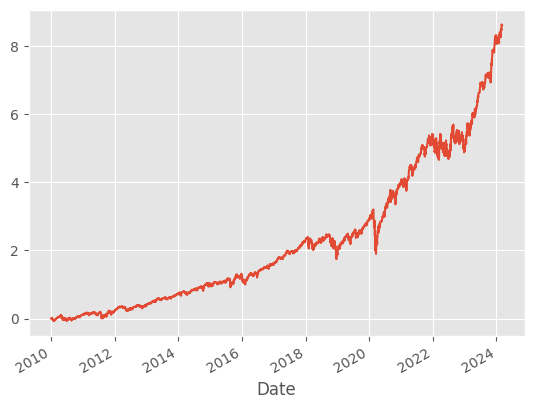

In [102]:
strategy_utils.get_cumulative_return(returns=strategy_returns.mean(axis=1).fillna(0.0), total=False).plot()

In [94]:
import matplotlib.pyplot as plt

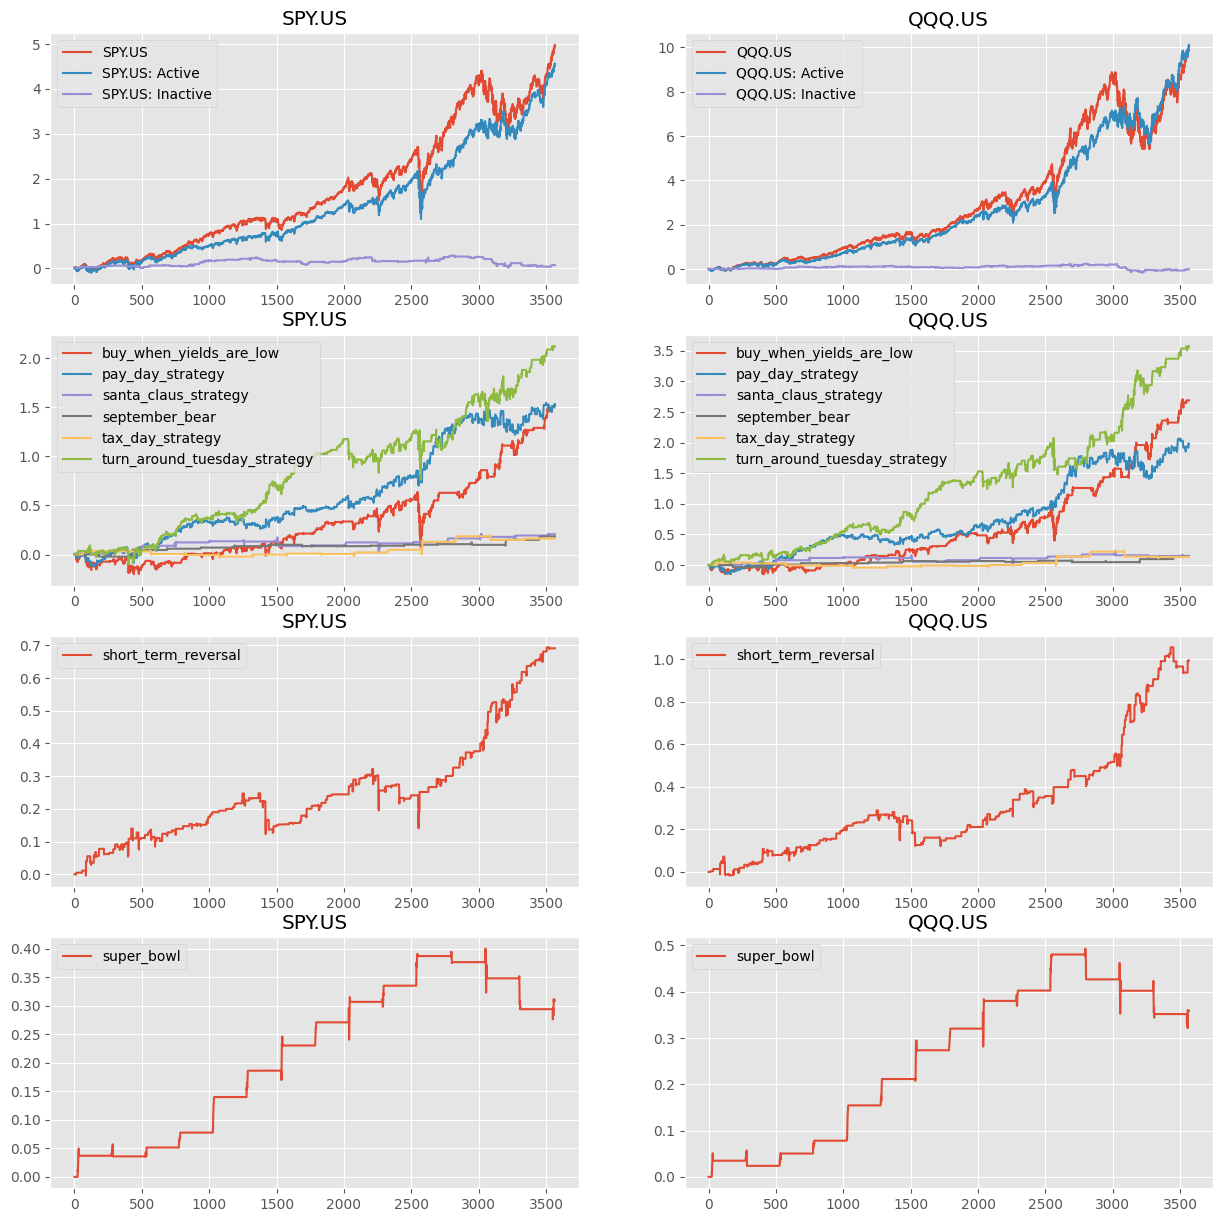

In [95]:
fig, ax = plt.subplots(figsize=(15, 15), nrows=1+len(set(cum_strat_returns.columns.get_level_values(0))), ncols=len(ASSETS)-1)#, sharex="col", sharey="all")

for j, asset in enumerate(ASSETS[:-1]):

    r = (asset_returns[asset].reset_index(drop=True) + 1).cumprod() - 1
    ra = (asset_returns.reset_index(drop=True).loc[(strat_active[asset] >= 1).values, asset] + 1).cumprod() - 1
    ri = (asset_returns.reset_index(drop=True).loc[(strat_active[asset] == 0).values, asset] + 1).cumprod() - 1

    ra = ra.reindex(index=r.index).ffill().fillna(0.0)
    ri = ri.reindex(index=r.index).ffill().fillna(0.0)
    
    ax[0][j].plot(r, label=asset)
    ax[0][j].plot(ra, label=f"{asset}: Active")
    ax[0][j].plot(ri, label=f"{asset}: Inactive")
    ax[0][j].legend(loc="upper left")
    ax[0][j].set_title(asset)

for i, col in enumerate(set(cum_strat_returns.columns.get_level_values(0))):
    i += 1
    r = cum_strat_returns.loc[:, cum_strat_returns.columns.get_level_values(0) == col].copy()
    for j, asset in enumerate(ASSETS[:-1]):
        ra = r.loc[:, r.columns.get_level_values(2) == asset].T.reset_index(level=[0, 2], drop=True).T.copy()
        for c in ra.columns:
            ax[i][j].plot(ra[c].reset_index(drop=True), label=c)
        ax[i][j].legend(loc="upper left")
        ax[i][j].set_title(asset)

plt.show()

In [96]:
pd.concat([
    strategy_utils.describe(returns=strategy_returns[col], pos=(~strategy_returns[col].isna()).astype(int), asset=col, daily=True)
    for col in strategy_returns.columns], axis=1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Asset,"(event_trading, super_bowl, SPY.US)","(event_trading, super_bowl, QQQ.US)","(overnight_trading, short_term_reversal, SPY.US)","(overnight_trading, short_term_reversal, QQQ.US)","(seasonal_trading, buy_when_yields_are_low, SP...","(seasonal_trading, buy_when_yields_are_low, QQ...","(seasonal_trading, pay_day_strategy, SPY.US)","(seasonal_trading, pay_day_strategy, QQQ.US)","(seasonal_trading, santa_claus_strategy, SPY.US)","(seasonal_trading, santa_claus_strategy, QQQ.US)","(seasonal_trading, september_bear, SPY.US)","(seasonal_trading, september_bear, QQQ.US)","(seasonal_trading, tax_day_strategy, SPY.US)","(seasonal_trading, tax_day_strategy, QQQ.US)","(seasonal_trading, turn_around_tuesday_strateg...","(seasonal_trading, turn_around_tuesday_strateg..."
Start,2010-01-04,2010-01-04,2010-01-04,2010-01-04,2010-01-04,2010-01-04,2010-01-04,2010-01-04,2010-01-04,2010-01-04,2010-01-04,2010-01-04,2010-01-04,2010-01-04,2010-01-04,2010-01-04
End,2024-03-05,2024-03-05,2024-03-05,2024-03-05,2024-03-05,2024-03-05,2024-03-05,2024-03-05,2024-03-05,2024-03-05,2024-03-05,2024-03-05,2024-03-05,2024-03-05,2024-03-05,2024-03-05
Mean Return,0.18370%,0.21083%,0.18119%,0.24002%,0.05923%,0.08308%,0.07818%,0.09366%,0.10254%,0.08005%,0.24648%,0.18720%,0.10819%,0.09268%,0.08913%,0.13182%
Total Return,30.94%,35.88%,69.08%,99.40%,150.92%,268.94%,152.81%,197.67%,20.67%,14.97%,18.42%,13.51%,16.18%,13.18%,211.98%,357.82%
Median Return,0.14416%,0.22459%,0.16954%,0.23040%,0.07779%,0.11578%,0.05349%,0.12206%,0.09695%,0.02174%,0.20441%,0.06898%,0.10197%,0.02917%,0.10403%,0.15790%
1st Quartile,-0.17659%,-0.29430%,-0.42665%,-0.55162%,-0.44209%,-0.53583%,-0.39184%,-0.48559%,-0.28857%,-0.52895%,-0.26654%,-0.38579%,-0.34507%,-0.42240%,-0.39241%,-0.50429%
3rd Quartile,0.59628%,0.74180%,0.80104%,0.96116%,0.64414%,0.79549%,0.63057%,0.75257%,0.57521%,0.71450%,0.77230%,0.81433%,0.67574%,0.76224%,0.66837%,0.82443%
Std Dev Return,0.87878%,1.11938%,1.33490%,1.55564%,1.23640%,1.40699%,1.07826%,1.30706%,0.96696%,1.22230%,0.97315%,1.10207%,1.11268%,1.30764%,1.23448%,1.41401%
CAGR,17.985 bps,20.459 bps,17.234 bps,22.802 bps,5.155 bps,7.316 bps,7.237 bps,8.512 bps,9.791 bps,7.266 bps,24.184 bps,18.124 bps,10.208 bps,8.425 bps,8.148 bps,12.178 bps


In [97]:
pd.concat([
    strategy_utils.describe(returns=asset_returns[col], pos=(~asset_returns[col].isna()).astype(int), asset=col, daily=True)
    for col in asset_returns.columns[:-1]
] + [
    strategy_utils.describe(
        returns=asset_returns[asset], 
        pos=(strat_active[asset] >= 1).astype(int), 
        asset=f"strat_on_{asset}",
        daily=True)
    for asset in ASSETS[:-1]
]
, axis=1)

,0,1,2,3
Asset,SPY.US,QQQ.US,strat_on_SPY.US,strat_on_QQQ.US
Start,2010-01-04,2010-01-04,2010-01-04,2010-01-04
End,2024-03-04,2024-03-04,2024-03-04,2024-03-04
Mean Return,0.05612%,0.07576%,0.06385%,0.09056%
Total Return,497.95%,"1,002.75%",456.28%,"1,007.42%"
Median Return,0.06591%,0.11483%,0.07279%,0.12272%
1st Quartile,-0.37397%,-0.47430%,-0.38077%,-0.47742%
3rd Quartile,0.57976%,0.72884%,0.59784%,0.75788%
Std Dev Return,1.08802%,1.29475%,1.11897%,1.32216%
CAGR,5.018 bps,6.735 bps,5.757 bps,8.180 bps


In [84]:
def run(N: int = np.inf):

    def train_model(X_train_: pd.DataFrame, y_train_: pd.DataFrame, name: str = None, **other_train_):
        
        OUTPUT_SHAPE = y_train_.shape[1]
        INPUT_SHAPE = X_train_.shape[1]

        my_net = model.Net(
            input_shape=INPUT_SHAPE, 
            output_shape=OUTPUT_SHAPE, 
            layer_sizes=[8, 16, 8], 
            allow_negative_weights=ALLOW_NEGATIVE_WEIGHTS, 
            max_weight=MAX_WEIGHT, 
            min_weight=MIN_WEIGHT,
        ).to(device=model.DEVICE)

        model.train(
            net=my_net, 
            name=name,
            X=X_train_, 
            y=y_train_, 
            loss_fn=LOSS_FUNCTION, 
            lr=LEARNING_RATE, 
            batch_size=BATCH_SIZE, 
            epochs=EPOCHS, 
            maximize_loss=MAXIMIZE_LOSS, 
            store=STORE,
            long_costs=LONG_OVERNIGHT_COSTS, 
            short_costs=SHORT_OVERNIGHT_COSTS, 
            # test_size=0.3,
            test_size=0.0,
            patience=20,
            min_delta=0.005,
            **other_train_,
        )

        return my_net
        
    
    # Get data
    X_grouped, y_grouped, other = utils.get_data(assets=ASSETS, file=FILE, start=START, end=END)
    X_raw, y_raw = utils.get_raw_data(assets=ASSETS, file=FILE, is_classification=False, start=START, end=END)

    X_grouped = X_grouped.loc[:, [col for col in X_grouped.columns if col[1] != "buy_when_yields_are_low"]]
    X_raw = X_raw.loc[:, X_raw.columns.get_level_values(1) != "buy_when_yields_are_low"]
    
    if X_grouped.index[0].date() > START:
        new_start = X_grouped.index[0].date()
    
    START_TRADING = dt.date(new_start.year + MIN_TRAINING_YEARS, 1, 1)
    
    # Fetch days to retrain model: quarterly
    retrain_dates = pd.date_range(start=START_TRADING, end=END, freq="6MS")

    all_strat_dicts_ = dict()
    i = 0
    for train_date, next_train_date in tqdm(zip(retrain_dates[:-1], retrain_dates[1:])):

        try:
            train_date = train_date.date()
            next_train_date = next_train_date.date()
    
            # Fetch training data: grouped data based on change in signals
            X_train, y_train = X_grouped.loc[X_grouped.index.date < train_date], y_grouped.loc[y_grouped.index.date < train_date]
            other_train = {key: value.loc[value.index.date < train_date] for key, value in other.items()}
    
            # Fetch testing data: raw data as would receive day-to-day
            if N == 0:
                X_test = X_raw.loc[X_raw.index.date >= train_date]
                y_test = y_raw.loc[y_raw.index.date >= train_date]
            else:
                X_test = X_raw.loc[(X_raw.index.date >= train_date) & (X_raw.index.date < next_train_date)]
                y_test = y_raw.loc[(y_raw.index.date >= train_date) & (y_raw.index.date < next_train_date)]
    
            my_net = train_model(X_train_=X_train, y_train_=y_train, name=f"{train_date:%Y%m%d}", **other_train)
            
            # Apply Model on test data
            strat_dict = utils.run(net=my_net, X_df=X_test, y_df=y_test, lost_costs=LONG_OVERNIGHT_COSTS, short_costs=SHORT_OVERNIGHT_COSTS)
    
            # Store 'strat_dict'
            all_strat_dicts_[train_date] = strat_dict
    
            for name, df in strat_dict.items():
                logger.info(f"{name = !r}: {strategy_utils.get_cumulative_return(returns=df['ret'], total=True):.3%}")
            print()
            
            if i >= N:
                break
            i += 1

        except KeyboardInterrupt:
            logger.warning("Received KeyboardInterrupt")
            break

    
    return all_strat_dicts_
    

In [ ]:
all_strat_dicts = run()

{}
remove api from here
{}
remove api from here


C:\Users\tomw1\PycharmProjects\quantified_strategies\quantified_strategies\scripts\pytorch_nn_asset_allocator\utils.py:26: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return_data = price_data.pct_change()


{}
remove api from here
{}
remove api from here


C:\Users\tomw1\PycharmProjects\quantified_strategies\quantified_strategies\scripts\pytorch_nn_asset_allocator\utils.py:26: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return_data = price_data.pct_change()
0it [00:00, ?it/s]2024-03-05 16:40:16.288 | INFO     | model:train:93 - Training: '20180101'
2024-03-05 16:40:16.434 | INFO     | model:train:130 - Epoch: 0 / 2000, Loss: 1.7355, Val Loss: 1.7355,Hit Rate: 58.82%, Val Hit Rate: 58.82%
2024-03-05 16:40:21.543 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.9371, Val Loss: 1.9371,Hit Rate: 58.35%, Val Hit Rate: 58.35%
2024-03-05 16:40:26.798 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 2.1005, Val Loss: 2.1005,Hit Rate: 57.39%, Val Hit Rate: 57.39%
2024-03-05 16:40:32.040 | INFO     | model:train:130 - Epoch: 150 / 2

2024-03-05 16:40:41.486 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.8162, Val Loss: 1.8162,Hit Rate: 58.99%, Val Hit Rate: 58.99%
2024-03-05 16:40:47.038 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 2.0055, Val Loss: 2.0055,Hit Rate: 58.99%, Val Hit Rate: 58.99%
2024-03-05 16:40:51.878 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 2.1009, Val Loss: 2.1009,Hit Rate: 59.44%, Val Hit Rate: 59.44%
2024-03-05 16:40:57.143 | INFO     | model:train:130 - Epoch: 200 / 2000, Loss: 2.1709, Val Loss: 2.1709,Hit Rate: 59.29%, Val Hit Rate: 59.29%
2024-03-05 16:41:01.674 | INFO     | model:train:130 - Epoch: 250 / 2000, Loss: 2.2153, Val Loss: 2.2153,Hit Rate: 59.14%, Val Hit Rate: 59.14%
2024-03-05 16:41:05.641 | INFO     | model:train:130 - Epoch: 300 / 2000, Loss: 2.2425, Val Loss: 2.2425,Hit Rate: 59.29%, Val Hit Rate: 59.29%
2024-03-05 16:41:12.015 | INFO     | model:train:130 - Epoch: 350 / 2000, Loss: 2.2621, Val Loss: 2.2621,Hit Rate: 59.29%, Val Hit Rate: 

2024-03-05 16:41:33.073 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.6259, Val Loss: 1.6259,Hit Rate: 58.42%, Val Hit Rate: 58.42%
2024-03-05 16:41:39.718 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 1.7069, Val Loss: 1.7069,Hit Rate: 58.42%, Val Hit Rate: 58.42%
2024-03-05 16:41:46.029 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 1.7652, Val Loss: 1.7652,Hit Rate: 58.42%, Val Hit Rate: 58.42%
2024-03-05 16:41:51.935 | INFO     | model:train:130 - Epoch: 200 / 2000, Loss: 1.8073, Val Loss: 1.8073,Hit Rate: 58.83%, Val Hit Rate: 58.83%
2024-03-05 16:41:57.899 | INFO     | model:train:130 - Epoch: 250 / 2000, Loss: 1.8685, Val Loss: 1.8685,Hit Rate: 58.56%, Val Hit Rate: 58.56%
2024-03-05 16:42:04.110 | INFO     | model:train:130 - Epoch: 300 / 2000, Loss: 1.9243, Val Loss: 1.9243,Hit Rate: 58.70%, Val Hit Rate: 58.70%
2024-03-05 16:42:10.063 | INFO     | model:train:130 - Epoch: 350 / 2000, Loss: 1.9449, Val Loss: 1.9449,Hit Rate: 58.70%, Val Hit Rate: 

2024-03-05 16:42:19.940 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.6361, Val Loss: 1.6361,Hit Rate: 59.37%, Val Hit Rate: 59.37%
2024-03-05 16:42:26.194 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 1.8342, Val Loss: 1.8342,Hit Rate: 59.11%, Val Hit Rate: 59.11%
2024-03-05 16:42:32.514 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 1.9513, Val Loss: 1.9513,Hit Rate: 59.11%, Val Hit Rate: 59.11%
2024-03-05 16:42:38.972 | INFO     | model:train:130 - Epoch: 200 / 2000, Loss: 1.9862, Val Loss: 1.9862,Hit Rate: 59.11%, Val Hit Rate: 59.11%
2024-03-05 16:42:45.394 | INFO     | model:train:130 - Epoch: 250 / 2000, Loss: 2.0008, Val Loss: 2.0008,Hit Rate: 59.11%, Val Hit Rate: 59.11%
2024-03-05 16:42:45.863 | INFO     | model:train:138 - Early Stopping reached @ epoch = 254! Best Loss: 1.9969220161437988, Loss: 2.001692533493042, Best Val Loss: 1.9969220161437988, Val Loss: 2.001692533493042, Hit Rate: 59.11%, Val Accuracy: 59.11%
2024-03-05 16:42:46.201 | INF

2024-03-05 16:42:53.210 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.8136, Val Loss: 1.8136,Hit Rate: 59.15%, Val Hit Rate: 59.15%
2024-03-05 16:43:00.004 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 1.9267, Val Loss: 1.9267,Hit Rate: 59.15%, Val Hit Rate: 59.15%
2024-03-05 16:43:07.137 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 1.9467, Val Loss: 1.9467,Hit Rate: 59.51%, Val Hit Rate: 59.51%
2024-03-05 16:43:07.533 | INFO     | model:train:138 - Early Stopping reached @ epoch = 153! Best Loss: 1.9431935548782349, Loss: 1.9471254348754883, Best Val Loss: 1.9431935548782349, Val Loss: 1.9471254348754883, Hit Rate: 59.51%, Val Accuracy: 59.51%
2024-03-05 16:43:07.845 | INFO     | __main__:run:84 - name = 'strat': 15.026%
2024-03-05 16:43:07.850 | INFO     | __main__:run:84 - name = 'benchmark': 15.794%
2024-03-05 16:43:07.855 | INFO     | __main__:run:84 - name = 'hodl': 12.111%
5it [02:51, 32.39s/it]2024-03-05 16:43:07.878 | INFO     | model:train:93 -

2024-03-05 16:43:08.091 | INFO     | model:train:130 - Epoch: 0 / 2000, Loss: 1.5763, Val Loss: 1.5763,Hit Rate: 59.53%, Val Hit Rate: 59.53%
2024-03-05 16:43:16.671 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.8339, Val Loss: 1.8339,Hit Rate: 59.53%, Val Hit Rate: 59.53%
2024-03-05 16:43:26.828 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 1.9674, Val Loss: 1.9674,Hit Rate: 59.75%, Val Hit Rate: 59.75%
2024-03-05 16:43:35.975 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 1.9912, Val Loss: 1.9912,Hit Rate: 59.53%, Val Hit Rate: 59.53%
2024-03-05 16:43:37.814 | INFO     | model:train:138 - Early Stopping reached @ epoch = 159! Best Loss: 1.9885324239730835, Loss: 1.9929176568984985, Best Val Loss: 1.9885324239730835, Val Loss: 1.9929176568984985, Hit Rate: 59.53%, Val Accuracy: 59.53%
2024-03-05 16:43:38.228 | INFO     | __main__:run:84 - name = 'strat': 13.935%
2024-03-05 16:43:38.230 | INFO     | __main__:run:84 - name = 'benchmark': 10.341%
2024-03-05 

2024-03-05 16:43:38.515 | INFO     | model:train:130 - Epoch: 0 / 2000, Loss: 1.4907, Val Loss: 1.4907,Hit Rate: 59.12%, Val Hit Rate: 59.12%
2024-03-05 16:43:50.603 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.7832, Val Loss: 1.7832,Hit Rate: 59.23%, Val Hit Rate: 59.23%
2024-03-05 16:44:05.293 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 1.9502, Val Loss: 1.9502,Hit Rate: 59.44%, Val Hit Rate: 59.44%
2024-03-05 16:44:37.505 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 1.9858, Val Loss: 1.9858,Hit Rate: 59.23%, Val Hit Rate: 59.23%
2024-03-05 16:45:22.610 | INFO     | model:train:138 - Early Stopping reached @ epoch = 197! Best Loss: 1.9933011531829834, Loss: 1.996887445449829, Best Val Loss: 1.9933011531829834, Val Loss: 1.996887445449829, Hit Rate: 59.44%, Val Accuracy: 59.44%
2024-03-05 16:45:24.053 | INFO     | __main__:run:84 - name = 'strat': 12.930%
2024-03-05 16:45:24.063 | INFO     | __main__:run:84 - name = 'benchmark': 17.002%
2024-03-05 16

2024-03-05 16:45:24.869 | INFO     | model:train:130 - Epoch: 0 / 2000, Loss: 1.4954, Val Loss: 1.4954,Hit Rate: 59.65%, Val Hit Rate: 59.65%
2024-03-05 16:45:59.652 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.8442, Val Loss: 1.8442,Hit Rate: 59.65%, Val Hit Rate: 59.65%
2024-03-05 16:46:16.522 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 1.9941, Val Loss: 1.9941,Hit Rate: 59.65%, Val Hit Rate: 59.65%
2024-03-05 16:46:31.228 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 2.0159, Val Loss: 2.0159,Hit Rate: 59.86%, Val Hit Rate: 59.86%
2024-03-05 16:46:40.850 | INFO     | model:train:138 - Early Stopping reached @ epoch = 174! Best Loss: 2.016812801361084, Loss: 2.0203754901885986, Best Val Loss: 2.016812801361084, Val Loss: 2.0203754901885986, Hit Rate: 59.96%, Val Accuracy: 59.96%
2024-03-05 16:46:41.470 | INFO     | __main__:run:84 - name = 'strat': 13.710%
2024-03-05 16:46:41.475 | INFO     | __main__:run:84 - name = 'benchmark': 12.898%
2024-03-05 16

2024-03-05 16:46:41.770 | INFO     | model:train:130 - Epoch: 0 / 2000, Loss: 1.6288, Val Loss: 1.6288,Hit Rate: 59.73%, Val Hit Rate: 59.73%
2024-03-05 16:47:00.529 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.8397, Val Loss: 1.8397,Hit Rate: 59.44%, Val Hit Rate: 59.44%
2024-03-05 16:47:16.322 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 1.9694, Val Loss: 1.9694,Hit Rate: 59.73%, Val Hit Rate: 59.73%
2024-03-05 16:47:32.810 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 1.9967, Val Loss: 1.9967,Hit Rate: 59.63%, Val Hit Rate: 59.63%
2024-03-05 16:47:37.741 | INFO     | model:train:138 - Early Stopping reached @ epoch = 168! Best Loss: 1.996155023574829, Loss: 2.000926971435547, Best Val Loss: 1.996155023574829, Val Loss: 2.000926971435547, Hit Rate: 59.63%, Val Accuracy: 59.63%
2024-03-05 16:47:38.337 | INFO     | __main__:run:84 - name = 'strat': -14.175%
2024-03-05 16:47:38.339 | INFO     | __main__:run:84 - name = 'benchmark': 1.901%
2024-03-05 16:4

2024-03-05 16:47:38.669 | INFO     | model:train:130 - Epoch: 0 / 2000, Loss: 1.4469, Val Loss: 1.4469,Hit Rate: 58.87%, Val Hit Rate: 58.87%
2024-03-05 16:47:54.036 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.6013, Val Loss: 1.6013,Hit Rate: 58.96%, Val Hit Rate: 58.96%
2024-03-05 16:48:05.114 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 1.6844, Val Loss: 1.6844,Hit Rate: 59.05%, Val Hit Rate: 59.05%
2024-03-05 16:48:16.501 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 1.7138, Val Loss: 1.7138,Hit Rate: 58.87%, Val Hit Rate: 58.87%
2024-03-05 16:48:29.984 | INFO     | model:train:130 - Epoch: 200 / 2000, Loss: 1.7268, Val Loss: 1.7268,Hit Rate: 58.96%, Val Hit Rate: 58.96%
2024-03-05 16:48:30.902 | INFO     | model:train:138 - Early Stopping reached @ epoch = 204! Best Loss: 1.7232104539871216, Loss: 1.7276076078414917, Best Val Loss: 1.7232104539871216, Val Loss: 1.7276076078414917, Hit Rate: 58.96%, Val Accuracy: 58.96%
2024-03-05 16:48:31.331 | INF

2024-03-05 16:48:31.585 | INFO     | model:train:130 - Epoch: 0 / 2000, Loss: 1.2305, Val Loss: 1.2305,Hit Rate: 58.70%, Val Hit Rate: 58.70%
2024-03-05 16:48:44.866 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.4353, Val Loss: 1.4353,Hit Rate: 58.53%, Val Hit Rate: 58.53%
2024-03-05 16:49:00.510 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 1.6102, Val Loss: 1.6102,Hit Rate: 58.18%, Val Hit Rate: 58.18%
2024-03-05 16:49:13.514 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 1.6521, Val Loss: 1.6521,Hit Rate: 57.49%, Val Hit Rate: 57.49%
2024-03-05 16:49:24.587 | INFO     | model:train:130 - Epoch: 200 / 2000, Loss: 1.6985, Val Loss: 1.6985,Hit Rate: 57.49%, Val Hit Rate: 57.49%
2024-03-05 16:49:35.705 | INFO     | model:train:130 - Epoch: 250 / 2000, Loss: 1.7316, Val Loss: 1.7316,Hit Rate: 57.92%, Val Hit Rate: 57.92%
2024-03-05 16:49:50.489 | INFO     | model:train:130 - Epoch: 300 / 2000, Loss: 1.7520, Val Loss: 1.7520,Hit Rate: 58.27%, Val Hit Rate: 58

In [6]:
# TODO: Fix update dataset to be progressive/sequential

In [ ]:
strat_df = pd.concat([strat_dict["strat"] for date, strat_dict in all_strat_dicts.items()], axis=0)
benchmark_df = pd.concat([strat_dict["benchmark"] for date, strat_dict in all_strat_dicts.items()], axis=0)
hodl_df = pd.concat([strat_dict["hodl"] for date, strat_dict in all_strat_dicts.items()], axis=0)

In [ ]:
FROM_DATE = dt.date(2010, 1, 1)
TO_DATE = dt.date(2023, 12, 31)

In [ ]:
hodl_df_ = hodl_df.loc[(hodl_df.index.date >= FROM_DATE) & (hodl_df.index.date <= TO_DATE)]
benchmark_df_ = benchmark_df.loc[(benchmark_df.index.date >= FROM_DATE) & (benchmark_df.index.date <= TO_DATE)]
strat_df_ = strat_df.loc[(strat_df.index.date >= FROM_DATE) & (strat_df.index.date <= TO_DATE)]

In [ ]:
hodl_ret = strategy_utils.get_cumulative_return(returns=hodl_df_["ret"], total=False)
benchmark_ret = strategy_utils.get_cumulative_return(returns=benchmark_df_["ret"], total=False)
strat_ret = strategy_utils.get_cumulative_return(returns=strat_df_["ret"], total=False)

hodl_pos = hodl_df_[[f"w_{asset}" for asset in ASSETS if asset != utils.CASH]].sum(axis=1)
benchmark_pos = benchmark_df_[[f"w_{asset}" for asset in ASSETS if asset != utils.CASH]].sum(axis=1)
strat_pos = strat_df_[[f"w_{asset}" for asset in ASSETS if asset != utils.CASH]].sum(axis=1)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
strat_df_[[f"w_{asset}" for asset in ASSETS if asset != utils.CASH]].plot()

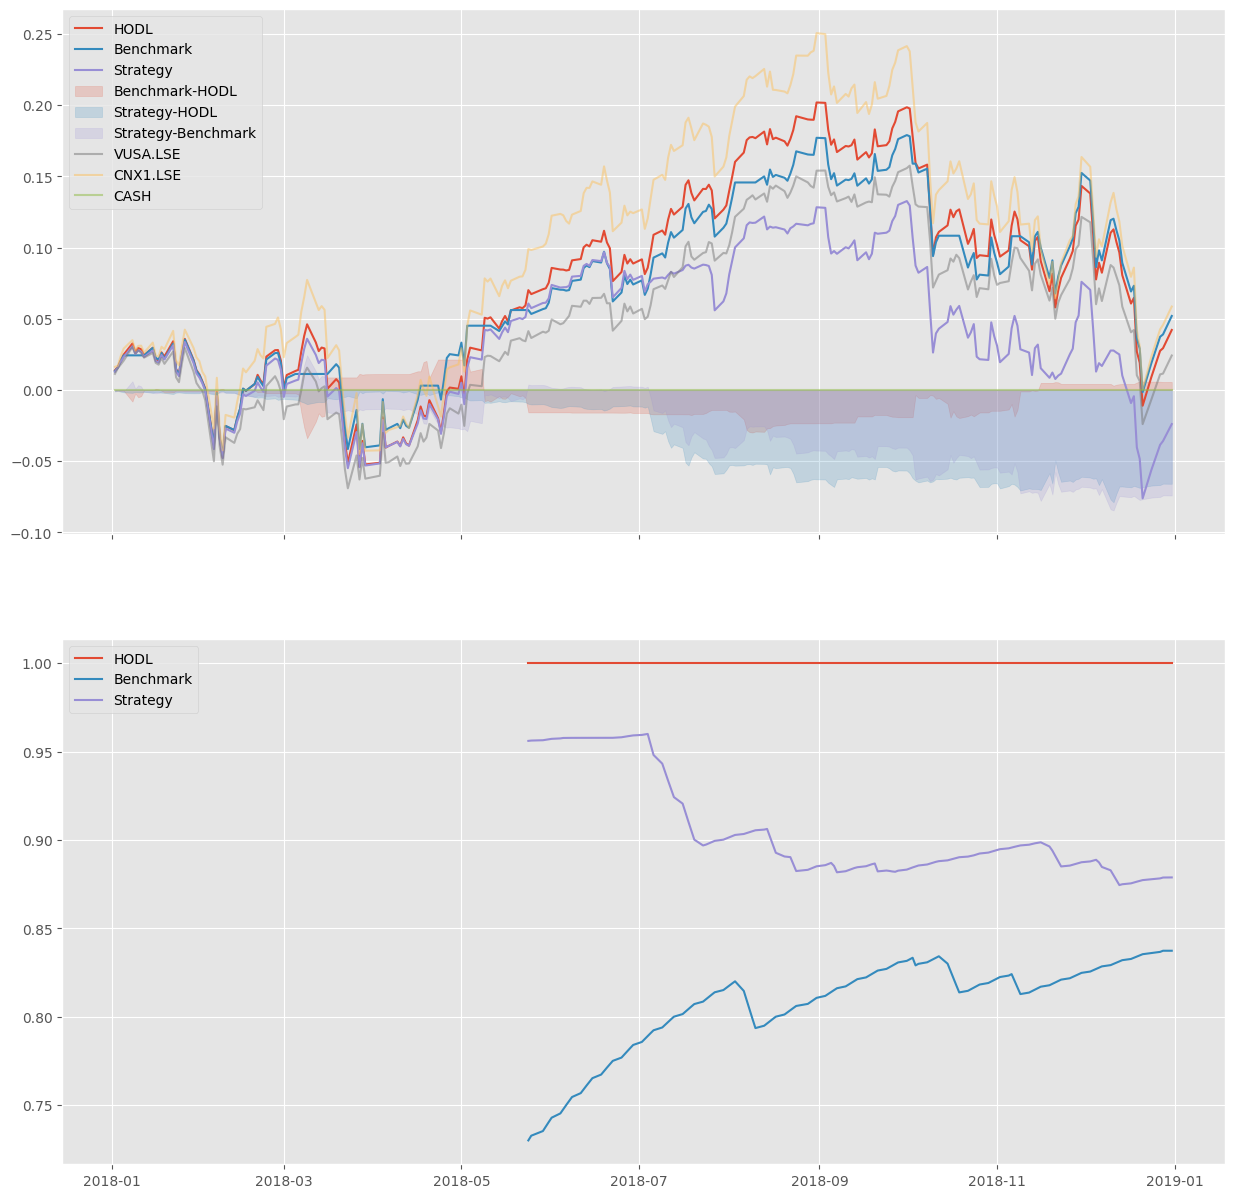

In [13]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

fig, ax = plt.subplots(figsize=(15, 15), sharex="col", nrows=2)

ax[0].plot(hodl_ret, label="HODL", color=colors[0])
ax[0].plot(benchmark_ret, label="Benchmark", color=colors[1])
ax[0].plot(strat_ret, label="Strategy", color=colors[2])

ax[0].fill_between(
    hodl_ret.index, 0, 
    strategy_utils.get_cumulative_return(returns=benchmark_df_["ret"]-hodl_df_["ret"], total=False), 
    color=colors[0],
    alpha=0.2,
    label="Benchmark-HODL",
)
ax[0].fill_between(
    hodl_ret.index, 0, 
    strategy_utils.get_cumulative_return(returns=strat_df_["ret"]-hodl_df_["ret"], total=False), 
    color=colors[1],
    alpha=0.2,
    label="Strategy-HODL",
)
ax[0].fill_between(
    hodl_ret.index, 0, 
    strategy_utils.get_cumulative_return(returns=strat_df_["ret"]-benchmark_df_["ret"], total=False), 
    color=colors[2],
    alpha=0.2,    
    label="Strategy-Benchmark",
)
for i, asset in enumerate(ASSETS):
    ax[0].plot(strategy_utils.get_cumulative_return(returns=hodl_df_[asset], total=False), label=asset, color=colors[3+i], alpha=0.5)
ax[0].legend(loc="upper left")

# Activity
ax[1].plot(hodl_pos.rolling(window=252, min_periods=100).mean(), label="HODL", color=colors[0])
ax[1].plot(benchmark_pos.rolling(window=252, min_periods=100).mean(), label="Benchmark", color=colors[1])
ax[1].plot(strat_pos.rolling(window=252, min_periods=100).mean(), label="Strategy", color=colors[2])
ax[1].legend(loc="upper left")

plt.show()


In [14]:
desc = pd.concat([
    strategy_utils.describe(returns=strat_df_["ret"], pos=strat_pos, daily=True).to_frame(name="strategy"),
    strategy_utils.describe(returns=benchmark_df_["ret"], pos=benchmark_pos, daily=True).to_frame(name="benchmark"),
    strategy_utils.describe(returns=hodl_df_["ret"], pos=hodl_pos, daily=True).to_frame(name="hodl")
], axis=1)
desc

,strategy,benchmark,hodl
Asset,Undefined,Undefined,Undefined
Start,2018-01-02,2018-01-02,2018-01-02
End,2018-12-31,2018-12-31,2018-12-31
Mean Return,-0.00325%,0.03122%,0.02326%
Total Return,-2.39%,5.20%,4.22%
Median Return,0.08754%,0.15912%,0.16162%
1st Quartile,-0.37991%,-0.48663%,-0.47646%
3rd Quartile,0.55699%,0.67732%,0.68733%
Std Dev Return,1.12338%,1.21019%,1.17770%
CAGR,-0.956 bps,2.391 bps,1.633 bps


<Axes: >

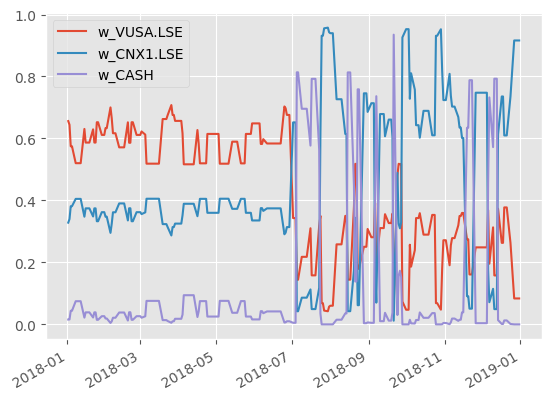

In [15]:
strat_df_[[f"w_{asset}" for asset in ASSETS]].plot()

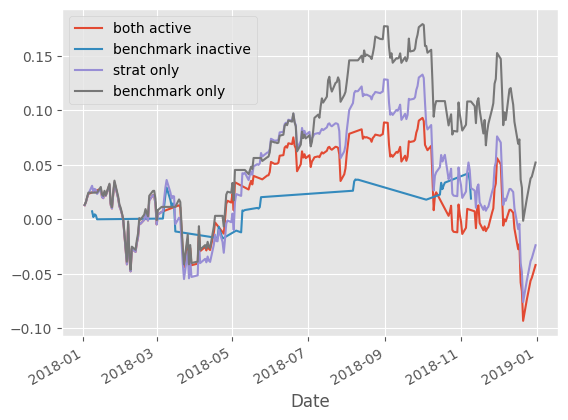

In [16]:
strategy_utils.get_cumulative_return(returns=strat_df_.loc[benchmark_df_[f"w_{utils.CASH}"] == 0.0, "ret"], total=False).plot(label="both active")
strategy_utils.get_cumulative_return(returns=strat_df_.loc[benchmark_df_[f"w_{utils.CASH}"] == 1.0, "ret"], total=False).plot(label="benchmark inactive")
strategy_utils.get_cumulative_return(returns=strat_df_.loc[:, "ret"], total=False).plot(label="strat only")
strategy_utils.get_cumulative_return(returns=benchmark_df_.loc[:, "ret"], total=False).plot(label="benchmark only")
plt.legend(loc="upper left")
plt.show()
